In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [4]:
!pip install h5py==2.10.0
!pip install q keras==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.1.0-py2.py3-none-any.whl (302 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [5]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/content


In [6]:
%cd Mask_RCNN
!pwd
!python3 setup.py install

/content/Mask_RCNN
/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/t

In [7]:
import os
import sys
import imagesize
import numpy as np
import math
from matplotlib import image

from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [8]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [9]:
ROOT_DIR = os.path.abspath("./")
print(ROOT_DIR)

DRIVE_ROOT_DIR = "/content/gdrive/My Drive/mrcnn"

DEFAULT_LOGS_DIR = os.path.join(DRIVE_ROOT_DIR, "logs")
print(DEFAULT_LOGS_DIR)

COCO_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_WEIGHTS_PATH)

LAST_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_floatingobjects_0050.h5")
print(LAST_WEIGHTS_PATH)

DATASET_DIR = os.path.join(DRIVE_ROOT_DIR, "dataset")
print(DATASET_DIR)

sys.path.append(ROOT_DIR)

/content/Mask_RCNN
/content/gdrive/My Drive/mrcnn/logs
/content/gdrive/My Drive/mrcnn/mask_rcnn_coco.h5
/content/gdrive/My Drive/mrcnn/mask_rcnn_floatingobjects_0050.h5
/content/gdrive/My Drive/mrcnn/dataset


In [10]:
class FloatingObjectsDataset(utils.Dataset):
    """
    Load a subset of Floating Objects dataset.
    dataset_dir: Root directory of the dataset.
    subset: Subset to load: train/validation/test
    """
    def load_objects(self, dataset_dir, subset):
        self.add_class("person", 1, "person")

        assert subset in ["train", "validation", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        """
        YOLO: In YOLO labeling format, a .txt file with the
        same name is created for each image file in the same
        directory. Each .txt contains he annotations for the
        corresponding image file, that is object class, object
        coordinates, height and width.
        <object-class> <x> <y> <width> <height>
        """
        annotations = {}
        for annotation_filename in os.listdir(dataset_dir):
            if annotation_filename.endswith(".txt"):
                annotation_file_path = f"{dataset_dir}/{annotation_filename}"
                raw_filename = os.path.splitext(annotation_filename)[0]
                with open(annotation_file_path, 'rb') as f:
                    elements = []
                    raw_data = f.read().splitlines()
                    for line in raw_data:
                        line = line.decode("utf-8")
                        single_annotaton = line.split(' ')
                        # Remove bounding boxes for non-persons
                        if (single_annotaton[0] != '0'):
                            continue
                        elements.append(single_annotaton)
                        if (len(elements) == 0):
                            continue
                    annotations[raw_filename] = elements

        # Load images
        images = {}
        for image_filename in os.listdir(dataset_dir):
            if image_filename.endswith(".jpg"):
                raw_filename = os.path.splitext(image_filename)[0]
                if len(annotations[raw_filename]) == 0:
                    continue
                image_file_path = f"{dataset_dir}/{image_filename}"
                width, height = imagesize.get(image_file_path)
                images[raw_filename] = {}
                images[raw_filename]['path'] = image_file_path
                images[raw_filename]['width'] = width
                images[raw_filename]['height'] = height
                images[raw_filename]['annotations'] = annotations[raw_filename]


        for key in images:
            self.add_image(
                "person",
                image_id=key,
                path=images[key]['path'],
                width=images[key]['width'],
                height=images[key]['height'],
                annotations=images[key]['annotations'])


    def yolo_to_box(self, yolo_annotation: list, img_width, img_height):
        """
        Trasform bounding boxes in YOLO 
        format to standard bounding boxes
        """
        x = float(yolo_annotation[1])
        y = float(yolo_annotation[2])
        width = float(yolo_annotation[3])
        height = float(yolo_annotation[4])

        x_min, y_min = int((x-width/2)* img_width), int((y-height/2)*img_height)
        x_max, y_max = int((x+width/2) * img_width), int((y+height/2)*img_height)

        return [x_min, y_min, x_max, y_max]

    def load_mask(self, image_id):
        """
        Generate instance mask for an image
        """
        info = self.image_info[image_id]

        # Transform bounding boxes in YOLO
        # format to standard bounding boxes
        boxes = []
        for element in info['annotations']:
            box = self.yolo_to_box(element, info['width'], info['height'])
            boxes.append(box)

        # Create one array for all masks, each on different channel
        masks = np.zeros([info['height'], info['width'], len(boxes)], dtype='uint8')

        # Create masks
        for index in range(len(boxes)):
            box = boxes[index]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, index] = 1

        return masks.astype(np.bool), np.ones([masks.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """
        Return the path of the image.
        """
        info = self.image_info[image_id]
        return info['path']

In [12]:
dataset_train = FloatingObjectsDataset()
dataset_train.load_objects(DATASET_DIR, "train")
dataset_train.prepare()

Train image count: 1532
Train class count: 2
  0. BG                                                
  1. person                                            


In [19]:
dataset_validation = FloatingObjectsDataset()
dataset_validation.load_objects(DATASET_DIR, "validation")
dataset_validation.prepare()

In [20]:
dataset_test = FloatingObjectsDataset()
dataset_test.load_objects(DATASET_DIR, "test")
dataset_test.prepare()

In [21]:
print("Train image count: {}".format(len(dataset_train.image_ids)))
print("Train class count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
  print("{:3}. {:50}".format(i, info['name']))

print("Validation image count: {}".format(len(dataset_validation.image_ids)))
print("Validation class count: {}".format(dataset_validation.num_classes))
for i, info in enumerate(dataset_validation.class_info):
  print("{:3}. {:50}".format(i, info['name']))

print("Test image count: {}".format(len(dataset_test.image_ids)))
print("Test class count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Train image count: 1532
Train class count: 2
  0. BG                                                
  1. person                                            
Validation image count: 214
Validation class count: 2
  0. BG                                                
  1. person                                            
Test image count: 361
Test class count: 2
  0. BG                                                
  1. person                                            


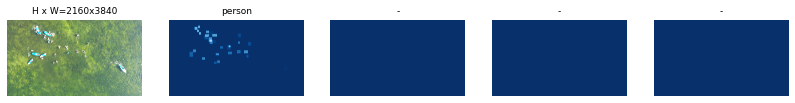

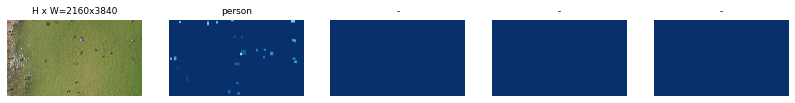

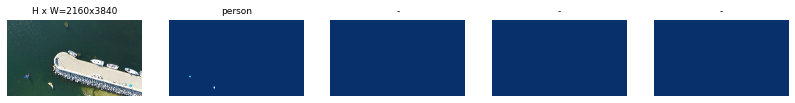

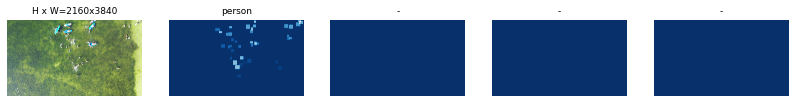

In [22]:
import mrcnn
from mrcnn import visualize
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Bounding boxes

image_id  44 /content/gdrive/My Drive/mrcnn/dataset/validation/w1_369.jpg
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2160, 3840, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min: 1736.00000  max: 2135.00000  int32


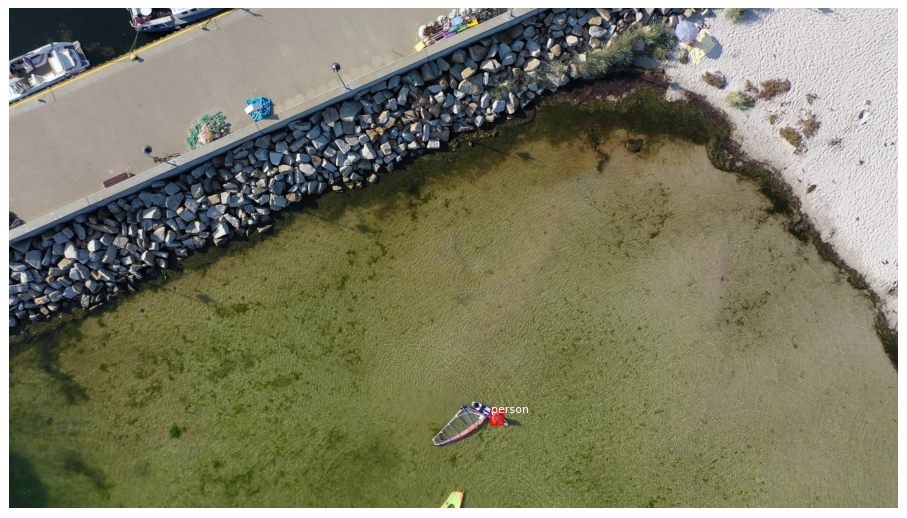

In [32]:
from mrcnn import utils
from mrcnn.model import log
import random

dataset = dataset_validation

image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  11 /content/gdrive/My Drive/mrcnn/dataset/validation/e_31.jpg
Original shape:  (2160, 3840, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 23)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (23,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (23, 4)               min:  221.00000  max: 1024.00000  int32


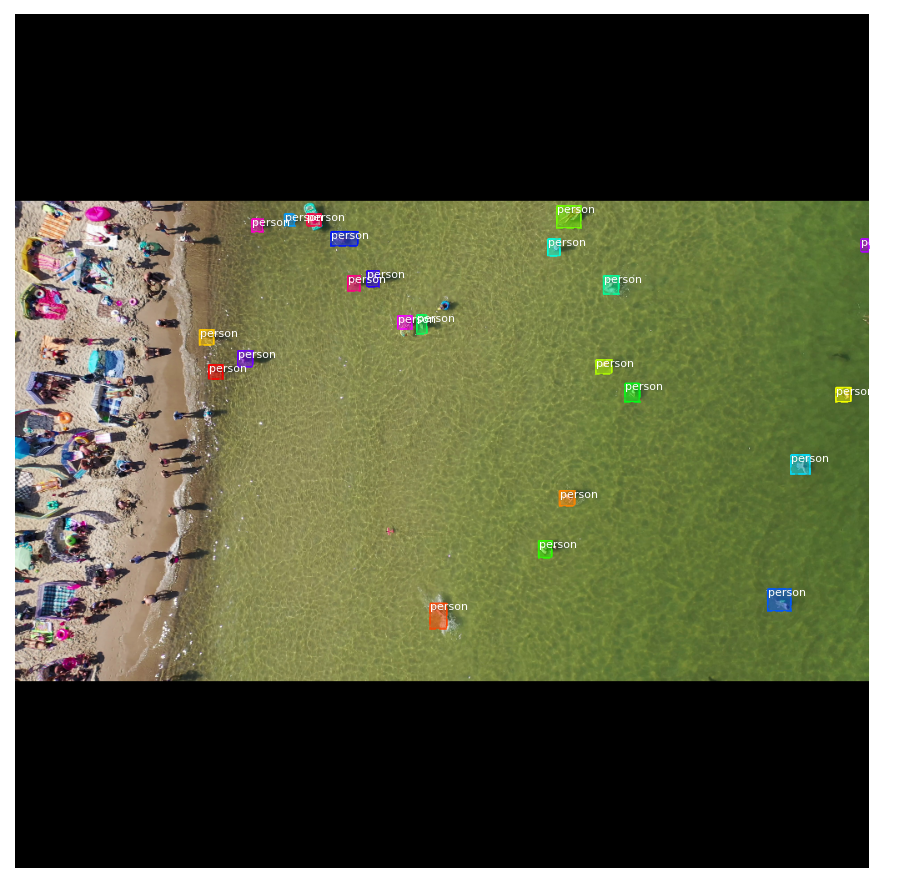

In [35]:
from mrcnn import config

class FloatingObjectsConfig(Config):
    NAME = "FloatingObjects"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes including background
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 10
    # Skip detection with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = FloatingObjectsConfig()

# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)